Guang Yang

Guangyang19@berkeley.edu

In [ ]:
!pip install numpy scipy soundfile


In [ ]:
!wget -O example.wav https://voiceage.com/wbsamples/in_mono/Classical.wav

--2024-08-17 09:19:06--  https://voiceage.com/wbsamples/in_mono/Classical.wav
Resolving voiceage.com (voiceage.com)... 24.37.80.233
Connecting to voiceage.com (voiceage.com)|24.37.80.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 943966 (922K) [audio/x-wav]
Saving to: ‘example.wav’

example.wav         100%[===================>] 921.84K  3.21MB/s    in 0.3s    

2024-08-17 09:19:07 (3.21 MB/s) - ‘example.wav’ saved [943966/943966]



In [ ]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

In [ ]:
def embed_message(input_filename, output_filename, message):

    rate, audio = wavfile.read(input_filename)
    if len(audio.shape) > 1:
        audio = audio[:, 0]  # Convert to mono by selecting the first channel
    audio = audio.copy()

    # Calculate message length in bits
    msg_len = 8 * len(message)
    # Calculate segment length, ensuring it's a power of 2
    seg_len = int(2 * 2**np.ceil(np.log2(2*msg_len)))
    # Calculate the number of segments needed
    seg_num = int(np.ceil(len(audio) / seg_len))

    # Resize the audio array to fit the number of segments
    audio.resize(seg_num * seg_len, refcheck=False)

    # Convert message to binary representation
    msg_bin = np.ravel([[int(y) for y in format(ord(x), '08b')] for x in message])
    # Convert binary to phase shifts (-pi/8 for 1, pi/8 for 0)
    msg_pi = msg_bin.copy()
    msg_pi[msg_pi == 0] = -1
    msg_pi = msg_pi * -np.pi / 2 # Use smaller phase to improve audio quality 1/8 may cause low BER, so change back to 1/2

    # Reshape audio into segments and perform FFT
    segs = audio.reshape((seg_num, seg_len))
    segs = np.fft.fft(segs)
    M = np.abs(segs)  # Magnitude
    P = np.angle(segs)  # Phase

    seg_mid = seg_len // 2

    # Embed message into the phase of the middle frequencies
    for i in range(seg_num):
        start = i * len(msg_pi) // seg_num
        end = (i + 1) * len(msg_pi) // seg_num
        P[i, seg_mid - (end - start):seg_mid] = msg_pi[start:end]
        P[i, seg_mid + 1:seg_mid + 1 + (end - start)] = -msg_pi[start:end][::-1]

    # Reconstruct the audio with modified phase
    segs = M * np.exp(1j * P)
    audio = np.fft.ifft(segs).real.ravel().astype(np.int16)

    # Write the modified audio to the output file
    wavfile.write(output_filename, rate, audio)

In [ ]:
def extract_message(input_filename, msg_len):
    # Read the input WAV file
    rate, audio = wavfile.read(input_filename)
    seg_len = int(2 * 2**np.ceil(np.log2(2*msg_len)))
    seg_num = int(np.ceil(len(audio) / seg_len))
    seg_mid = seg_len // 2

    extracted_bits = []

    # Extract the embedded message from the phase of the middle frequencies
    for i in range(seg_num):
        x = np.fft.fft(audio[i * seg_len:(i + 1) * seg_len])
        extracted_phase = np.angle(x)
        start = i * msg_len // seg_num
        end = (i + 1) * msg_len // seg_num
        extracted_bits.extend((extracted_phase[seg_mid - (end - start):seg_mid] < 0).astype(np.int8))

    extracted_bits = np.array(extracted_bits[:msg_len])
    # Convert binary bits back to characters
    chars = extracted_bits.reshape((-1, 8)).dot(1 << np.arange(8 - 1, -1, -1)).astype(np.uint8)
    message = ''.join(chr(c) for c in chars)
    return message

In [ ]:
def calculate_accuracy(original_msg, extracted_msg):
    # to binary
    original_bits = ''.join(f'{ord(c):08b}' for c in original_msg)
    extracted_bits = ''.join(f'{ord(c):08b}' for c in extracted_msg)

    # calculate BER
    total_bits = len(original_bits)
    incorrect_bits = sum(o != e for o, e in zip(original_bits, extracted_bits))
    bit_error_rate = incorrect_bits / total_bits

    # check message
    message_accuracy = 1 if original_msg == extracted_msg else 0

    return bit_error_rate, message_accuracy

In [ ]:
def calculate_max_message_length(input_filename):
    # Read the input WAV file
    rate, audio = wavfile.read(input_filename)
    if len(audio.shape) > 1:
        audio = audio[:, 0]  # Convert to mono by selecting the first channel
    audio_len = len(audio)

    # Determine the segment length based on the audio length
    seg_len = int(2 * 2**np.ceil(np.log2(2*audio_len)))  # Calculate segment length ensuring it's a power of 2

    # Calculate the number of segments
    seg_num = int(np.ceil(audio_len / seg_len))

    # Determine the maximum bits that can be embedded
    max_bits_per_seg = (seg_len // 2 - 1) // 2  # Calculate the number of bits per segment to embed the message
    max_bits = seg_num * max_bits_per_seg

    # Convert bits to bytes
    max_bytes = max_bits // 8

    return max_bytes

In [ ]:
import numpy as np
import wave
import matplotlib.pyplot as plt
from scipy.io import wavfile

def find_non_zero_segment(audio, seg_len=1024):
    # Find a segment with non-zero samples
    for i in range(0, len(audio), seg_len):
        segment = audio[i:i+seg_len]
        if np.max(segment) > 0:
            return segment
    # If no non-zero segment is found, return the first segment
    return audio[:seg_len]

def plot_spectrum_and_phase(original_audio, modified_audio, rate, message):
    # Calculate message length in bits
    msg_len = 8 * len(message)
    # Calculate segment length, ensuring it's a power of 2
    seg_len = int(2 * 2**np.ceil(np.log2(2*msg_len)))

    original_segment = find_non_zero_segment(original_audio, seg_len)
    modified_segment = find_non_zero_segment(modified_audio, seg_len)

    # Print basic information about the audio segments
    print("Original Audio Segment Stats")
    print(f"Min value: {np.min(original_segment)}")
    print(f"Max value: {np.max(original_segment)}")
    print(f"Mean value: {np.mean(original_segment)}")
    print(f"First 10 samples: {original_segment[:10]}")

    print("Modified Audio Segment Stats")
    print(f"Min value: {np.min(modified_segment)}")
    print(f"Max value: {np.max(modified_segment)}")
    print(f"Mean value: {np.mean(modified_segment)}")
    print(f"First 10 samples: {modified_segment[:10]}")

    # Check if the segments contain all zeros
    if np.max(original_segment) == 0 or np.max(modified_segment) == 0:
        print("One or both segments contain only zeros.")
        return

    # Normalize the audio segments
    original_segment = original_segment / np.max(np.abs(original_segment))
    modified_segment = modified_segment / np.max(np.abs(modified_segment))

    original_segs = np.fft.fft(original_segment)
    modified_segs = np.fft.fft(modified_segment)

    original_M = np.abs(original_segs)
    original_P = np.angle(original_segs)

    modified_M = np.abs(modified_segs)
    modified_P = np.angle(modified_segs)

    # Calculate the frequency bins
    freqs = np.fft.fftfreq(seg_len, 1/rate)

    plt.figure(figsize=(12, 18))

    # Plot time-domain comparison
    plt.subplot(3, 1, 1)
    plt.plot(original_segment, label='Original', color='blue')
    plt.plot(modified_segment, label='Modified', color='red')
    plt.title('Time-Domain Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot spectrum comparison
    plt.subplot(3, 1, 2)
    plt.plot(freqs[:seg_len // 2], original_M[:seg_len // 2], label='Original', color='blue')
    plt.plot(freqs[:seg_len // 2], modified_M[:seg_len // 2], label='Modified', color='red')
    plt.title('Spectrum Comparison')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()

    # Plot phase comparison
    plt.subplot(3, 1, 3)
    plt.plot(freqs[:seg_len // 2], original_P[:seg_len // 2], label='Original', color='blue')
    plt.plot(freqs[:seg_len // 2], modified_P[:seg_len // 2], label='Modified', color='red')
    plt.title('Phase Comparison')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_audio_spectrums(original_file, modified_file, message):
    # Read original audio file
    rate, original_audio = wavfile.read(original_file)
    if len(original_audio.shape) > 1:
        original_audio = original_audio[:, 0]  # Convert to mono by selecting the first channel

    # Check if the entire audio contains valid data
    print(f"Original Audio - Entire File Stats")
    print(f"Min value: {np.min(original_audio)}")
    print(f"Max value: {np.max(original_audio)}")
    print(f"Mean value: {np.mean(original_audio)}")

    # Read modified audio file
    rate, modified_audio = wavfile.read(modified_file)
    if len(modified_audio.shape) > 1:
        modified_audio = modified_audio[:, 0]  # Convert to mono by selecting the first channel

    # Check if the entire audio contains valid data
    print(f"Modified Audio - Entire File Stats")
    print(f"Min value: {np.min(modified_audio)}")
    print(f"Max value: {np.max(modified_audio)}")
    print(f"Mean value: {np.mean(modified_audio)}")

    # Plot original and modified spectrums and phases
    plot_spectrum_and_phase(original_audio, modified_audio, rate, message)


In [ ]:
input_filename = 'example.wav'  # short audio
# input_filename = 'example.wav'  # long audio

output_filename = 'improve_phase_coding.wav'

message = "testtest"



max_length = calculate_max_message_length(input_filename)

print(f"Maximum message length in bytes: {max_length}")

embed_message(input_filename, output_filename, message)

extracted_message = extract_message(output_filename, 8 * len(message))



print(f'Extracted Message: {extracted_message}')

ber, accuracy = calculate_accuracy(message, extracted_message)

print(f'Bit Error Rate (BER): {ber:.2%}')

print(f'Message Accuracy: {"Correct" if accuracy else "Incorrect"}')



Maximum message length in bytes: 65535
Extracted Message: testtest
Bit Error Rate (BER): 0.00%
Message Accuracy: Correct


In [ ]:
from IPython.display import Audio, display


display(Audio(filename=input_filename, autoplay=False))

display(Audio(filename=output_filename, autoplay=False))


Original Audio - Entire File Stats
Min value: -18700
Max value: 14815
Mean value: 4.715823976981149
Modified Audio - Entire File Stats
Min value: -18700
Max value: 14815
Mean value: 4.710285046095445
Original Audio Segment Stats
Min value: -8755
Max value: 11061
Mean value: 627.142578125
First 10 samples: [ 522  809  994 1164 1196 1271 1359 1505 1574 1595]
Modified Audio Segment Stats
Min value: -8755
Max value: 11061
Mean value: 627.052734375
First 10 samples: [ 521  808  993 1163 1195 1270 1358 1504 1573 1594]


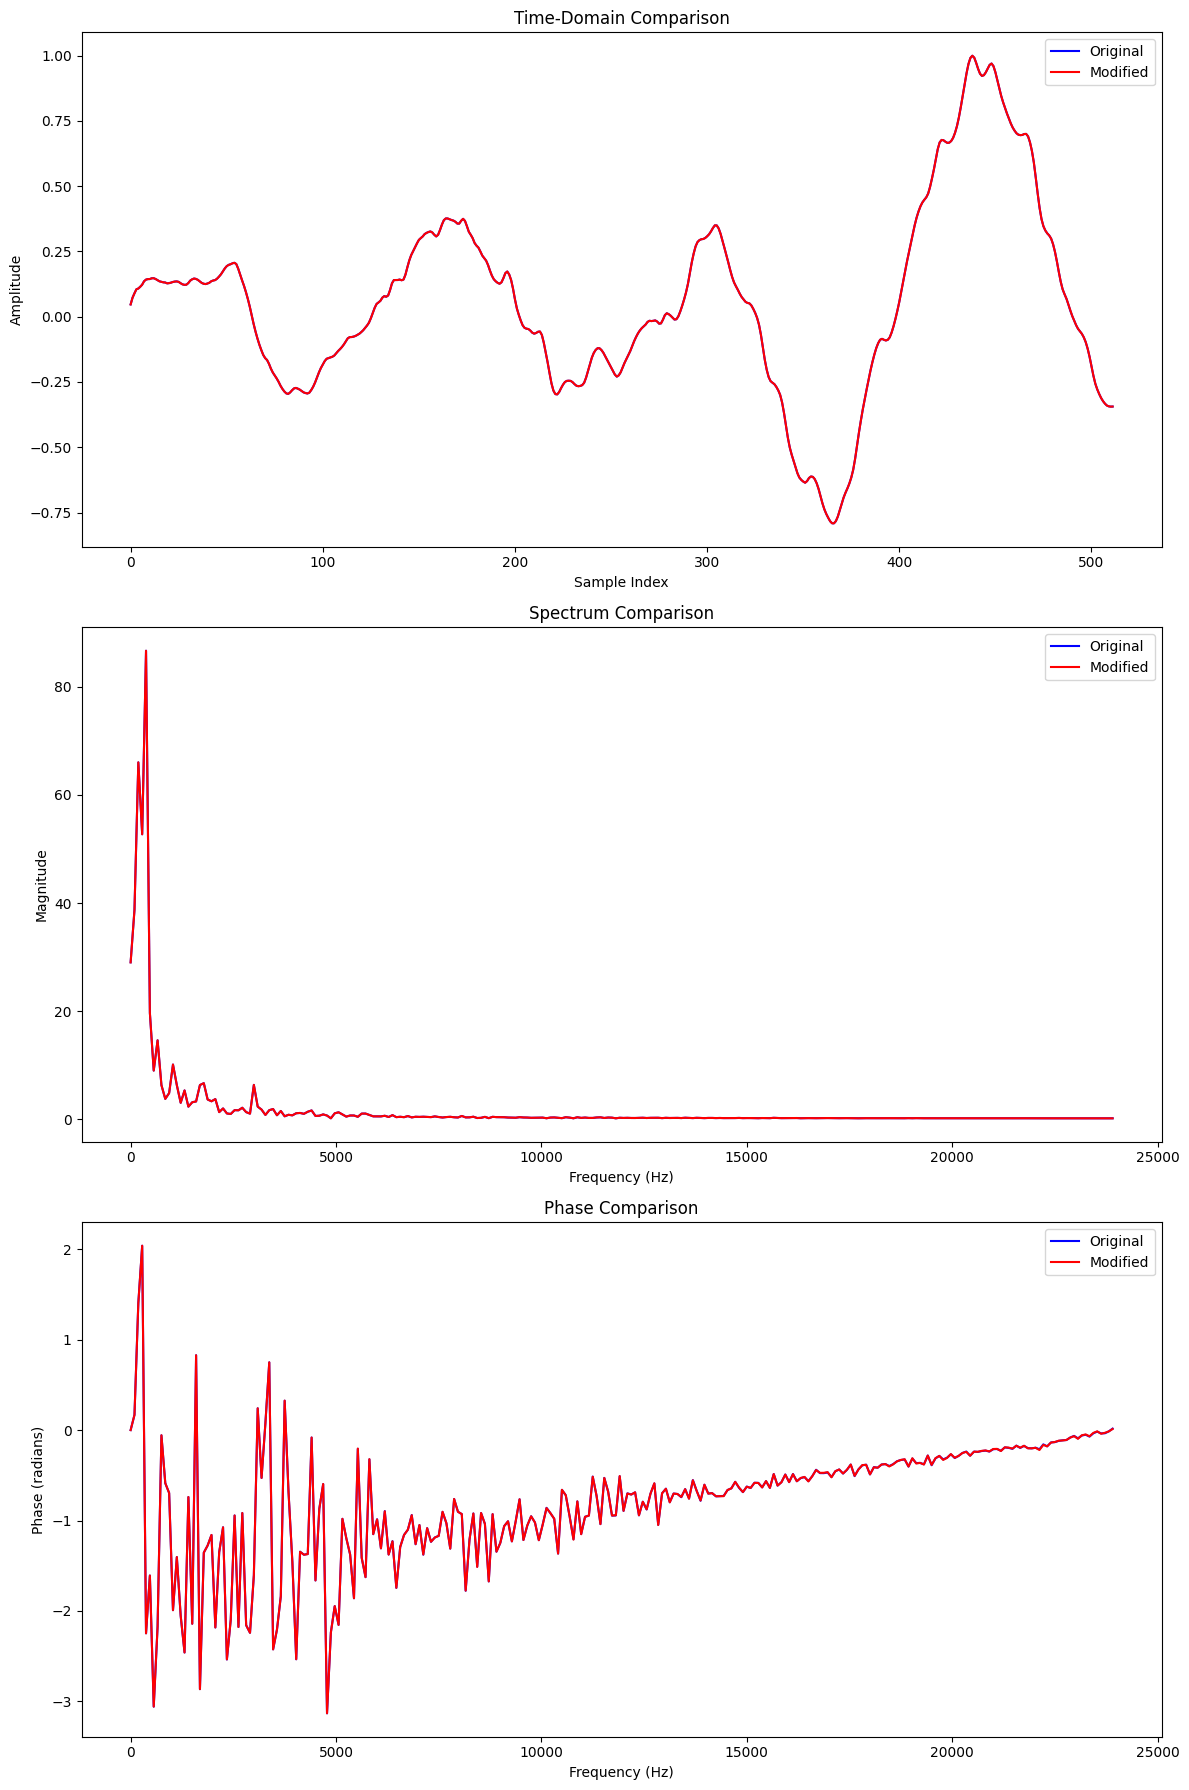

In [ ]:
plot_audio_spectrums(input_filename, output_filename, message)